In [1]:
#imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from datetime import date
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Input train/test data

In [2]:
df = pd.read_csv("shop_data.csv", index_col = 0)
df.sort_values("date", ascending = False)

C:\Users\neoch\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
661695,77225749,17,33,3318,102840020,15441.0,2013-07-23,10.0,OZ,1.0,3.00
685083,78057763,95,57,5705,103663232,4568.0,2013-07-23,16.0,OZ,1.0,2.29
685081,78057763,95,56,5615,107283070,18390.0,2013-07-23,32.0,OZ,1.0,6.08
685080,78057763,95,9,902,104400040,12279.0,2013-07-23,16.0,OZ,1.0,2.99
685079,78057763,95,22,2207,104650040,16355.0,2013-07-23,22.0,OZ,1.0,2.99
...,...,...,...,...,...,...,...,...,...,...,...
321652,57426577,4,5,501,103800030,4352.0,2012-03-02,14.1,OZ,1.0,2.50
321651,57426577,4,9,901,102113020,15704.0,2012-03-02,5.8,OZ,1.0,2.49
321650,57426577,4,25,2506,104410040,8481.0,2012-03-02,32.0,OZ,1.0,3.69
321649,57426577,4,18,1829,106233868,319.0,2012-03-02,1.0,CT,2.0,5.00


In [3]:
#date of purchase relative to most recent purchase in days
df["date"] = pd.to_datetime(df["date"])
df["today"] = "2013-07-23"
df["today"] = pd.to_datetime(df["today"])
df["date_rel"] = df["today"] - df["date"]
df.pop("today")

#changing deltatime days object to int
df['date_rel'] = df.date_rel.dt.days 

#reordering for readability
df = df[['id', 'chain', 'dept', 'category', 'company', 'brand', 'date','date_rel', 'productsize', 'productmeasure', 'purchasequantity', 'purchaseamount']]

In [4]:
#Split train, test
X_train, X_test = train_test_split(df, train_size=0.8, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

(920000, 12)
(230000, 12)


In [5]:
#create target variable by checking if num trips in last 60 days > 1 
#visits_60 = num visits in last 60 days
#repeat = indicator of repeat customer 
X_train2 = X_train.copy()
X_train2 = X_train2[X_train2['date_rel'] <= 60]
X_train2['visits_60'] = X_train2.groupby('id')['date'].transform("nunique")
X_train2['repeat'] = X_train2['visits_60'].apply(lambda x: 1 if x > 1 else 0)
X_train2.sort_values('repeat')
X_train = X_train.merge(X_train2.drop_duplicates(), how = "left")

#fill in NaN of customers who visited last 60 days and before that for date_rel older than 60
#The x.mean is just the same constant as visits_60 for that customer
X_train['visits_60'] = X_train.groupby(['id'], sort=False)['visits_60'].apply(lambda x: x.fillna(x.mean()))
X_train['repeat'] = X_train.groupby(['id'], sort=False)['repeat'].apply(lambda x: x.fillna(x.mean()))

#fill in all other customers
X_train['visits_60'] = X_train['visits_60'].fillna(0)
X_train['repeat'] = X_train['repeat'].fillna(0)

#float to int
X_train = X_train.astype({"visits_60":'int', "repeat":'int'}) 

In [6]:
#same to test
X_test2 = X_test.copy()
X_test2 = X_test2[X_test2['date_rel'] <= 60]
X_test2['visits_60'] = X_test2.groupby('id')['date'].transform("nunique")
X_test2['repeat'] = X_test2['visits_60'].apply(lambda x: 1 if x > 1 else 0)
X_test2.sort_values('repeat')
X_test = X_test.merge(X_test2.drop_duplicates(), how = "left")

#fill in NaN of customers who visited last 60 days and before that 
X_test['visits_60'] = X_test.groupby(['id'], sort=False)['visits_60'].apply(lambda x: x.fillna(x.mean()))
X_test['repeat'] = X_test.groupby(['id'], sort=False)['repeat'].apply(lambda x: x.fillna(x.mean()))

#fill in other customers
X_test['visits_60'] = X_test['visits_60'].fillna(0)
X_test['repeat'] = X_test['repeat'].fillna(0)

#float to int
X_test = X_test.astype({"visits_60":'int', "repeat":'int'}) 

#get y 
y_train = X_train.repeat
y_test = X_test.repeat

#We will drop these after EDA
#X_train.drop(columns=['repeat'], inplace=True)
#X_test.drop(columns=['repeat'], inplace=True)

# Data Cleaning

In [7]:
X_train.isnull().sum()

id                      0
chain                   0
dept                    0
category                0
company                 0
brand               62042
date                    0
date_rel                0
productsize             0
productmeasure      11937
purchasequantity       42
purchaseamount        255
visits_60               0
repeat                  0
dtype: int64

In [8]:
X_train.nunique()

id                  1215
chain                 12
dept                  82
category             776
company             4896
brand               5548
date                 509
date_rel             509
productsize         1190
productmeasure         6
purchasequantity      59
purchaseamount      5752
visits_60             33
repeat                 2
dtype: int64

We have null values in brand, productmeasure, purchasequantity, and purchaseamount
### Brand

In [9]:
#brand NA values in chain 14 
print(X_train.query('chain == 14').shape)
X_train[X_train['brand'].isnull()]

(62042, 14)


,id,chain,dept,category,company,brand,date,date_rel,productsize,productmeasure,purchasequantity,purchaseamount,visits_60,repeat
4,97065108,14,18,1829,1085032888,NaN,2013-02-17,156,1.00,CT,1.0,6.99,0,0
20,89319101,14,45,4508,102113020,NaN,2013-04-21,93,12.00,OZ,1.0,7.99,0,0
25,77760889,14,63,6320,1071514171,NaN,2012-09-09,317,12.00,CT,1.0,2.99,0,0
33,60983202,14,11,1102,101360010,NaN,2013-05-25,59,160.00,CT,1.0,6.99,7,1
37,84196639,14,64,6409,1072631979,NaN,2012-09-29,297,0.75,LT,7.0,125.93,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919957,77169013,14,5,502,1071219979,NaN,2013-03-30,115,0.75,OZ,2.0,1.18,0,0
919961,97110346,14,9,908,102430020,NaN,2013-02-20,153,8.27,OZ,2.0,3.76,6,1
919978,92736314,14,29,2908,104430040,NaN,2012-12-16,219,16.00,OZ,1.0,0.89,0,0
919981,90548180,14,5,501,103800030,NaN,2013-01-18,186,17.70,OZ,1.0,3.99,0,0


In [10]:
X_train_brand_mode = X_train.brand.mode().iat[0]
X_test_brand_mode = X_test.brand.mode().iat[0]

X_train.brand.fillna(X_train_brand_mode, inplace=True)
X_test.brand.fillna(X_test_brand_mode, inplace=True)

#Since no NA, we can change float to int 
X_train.brand = X_train.brand.astype(int)
X_test.brand = X_test.brand.astype(int)

### Product Measure

In [11]:
#productmeasure is NA when productsize == 0 
X_train[X_train['productmeasure'].isnull()]

,id,chain,dept,category,company,brand,date,date_rel,productsize,productmeasure,purchasequantity,purchaseamount,visits_60,repeat
19,22735677,18,96,9609,1053377656,88199,2012-03-06,504,0.0,NaN,1.0,-0.75,1,0
161,96909080,15,96,9609,1051380050,88199,2013-04-10,104,0.0,NaN,1.0,-1.00,16,1
177,86990589,17,96,9609,1050800454,88199,2012-09-01,325,0.0,NaN,2.0,-4.00,0,0
238,97252136,3,0,0,10000,0,2012-07-03,385,0.0,NaN,1.0,4.89,0,0
239,15753725,17,96,9609,1052580050,88199,2012-10-21,275,0.0,NaN,1.0,-1.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919828,49240577,18,96,9609,1059955555,88199,2012-07-31,357,0.0,NaN,1.0,-1.00,0,0
919858,21303030,95,96,9609,1053663252,88199,2013-03-09,136,0.0,NaN,1.0,-1.00,15,1
919863,76155746,95,96,9609,1053700050,88199,2013-05-10,74,0.0,NaN,1.0,-0.25,0,0
919877,49332997,14,96,9609,1055703757,15704,2012-06-08,410,0.0,NaN,2.0,-1.00,14,1


In [12]:
#Seems to be a separate category of items so we create a new category
X_train.productmeasure.fillna("NA", inplace = True)
X_test.productmeasure.fillna("NA", inplace = True)

### Purchase Quantity

In [13]:
#purchasequantity is NA for one customer with products measured in OZ
X_train[X_train['purchasequantity'].isnull()]

,id,chain,dept,category,company,brand,date,date_rel,productsize,productmeasure,purchasequantity,purchaseamount,visits_60,repeat
2234,44975538,2,58,5827,101111010,9907,2012-10-21,275,16.00,OZ,NaN,3.99,0,0
15875,44975538,2,58,5823,104450040,8318,2013-01-22,182,9.00,OZ,NaN,5.98,0,0
16653,44975538,2,58,5827,101111010,9907,2012-08-16,341,16.00,OZ,NaN,7.98,0,0
18401,44975538,2,58,5811,1071516676,27806,2012-11-18,247,3.00,OZ,NaN,2.98,0,0
18595,44975538,2,58,5811,1082652080,29786,2012-04-01,478,16.00,OZ,NaN,6.99,0,0
48229,44975538,2,58,5814,104470040,10837,2012-06-19,399,10.60,OZ,NaN,2.99,0,0
73820,44975538,2,58,5823,104470040,13310,2012-03-14,496,12.00,OZ,NaN,4.99,0,0
140547,44975538,2,58,5827,101111010,9907,2012-12-01,234,16.00,OZ,NaN,7.98,0,0
160788,44975538,2,58,5824,107778272,9260,2013-01-06,198,19.00,OZ,NaN,5.99,0,0
207884,44975538,2,58,5834,103760030,8501,2012-11-22,243,12.00,OZ,NaN,3.99,0,0


In [14]:
#We impute with the average purchase quantity for OZ
X_train['purchasequantity'] = X_train.groupby(['productmeasure'], sort=False)['purchasequantity'].apply(lambda x: x.fillna(x.mean()))
X_test['purchasequantity'] = X_test.groupby(['productmeasure'], sort=False)['purchasequantity'].apply(lambda x: x.fillna(x.mean()))

### Purchase Amount

In [15]:
#Similar situation, all productmeasures CT in chain 3 dept 5 have null purchase amt
print(X_train.query('chain == 3 and dept == 95 and productmeasure == "CT"').shape)
X_train[X_train['purchaseamount'].isnull()]

(255, 14)


,id,chain,dept,category,company,brand,date,date_rel,productsize,productmeasure,purchasequantity,purchaseamount,visits_60,repeat
1518,97252136,3,95,9518,1061029060,7848,2012-09-10,316,1.0,CT,4.0,NaN,0,0
4571,58161301,3,95,9518,1072047373,7848,2013-02-14,159,1.0,CT,1.0,NaN,12,1
8604,14049441,3,95,9518,107000070,7848,2012-11-06,259,1.0,CT,2.0,NaN,10,1
10959,97252136,3,95,9518,1072047373,7848,2013-02-22,151,1.0,CT,1.0,NaN,0,0
14004,75677935,3,95,9518,1061029060,7848,2012-05-10,439,1.0,CT,2.0,NaN,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907975,73719666,3,95,9518,1072047373,7848,2013-03-02,143,1.0,CT,2.0,NaN,0,0
908920,23763655,3,95,9518,1061029060,7848,2013-06-01,52,1.0,CT,1.0,NaN,9,1
913309,97252136,3,95,9518,1061029060,7848,2012-12-23,212,1.0,CT,2.0,NaN,0,0
915398,81848970,3,95,9518,1072047373,7848,2013-01-12,192,1.0,CT,1.0,NaN,8,1


In [16]:
#All NA values had productmeasure CT and productsize 1.0
train_purchase_mean = X_train.query('productmeasure == "CT" and productsize == 1.0')['purchaseamount'].mean()
X_train.purchaseamount.fillna(train_purchase_mean, inplace=True)

test_purchase_mean = X_test.query('productmeasure == "CT" and productsize == 1.0')['purchaseamount'].mean()
X_test.purchaseamount.fillna(test_purchase_mean, inplace=True)

# Data Exploration

In [17]:
#Lets take a look at basic statistics for numerical variables
#Sampling 50k rows to reduce load times
numerical = X_train[['date_rel', 'productsize', 'purchasequantity', 'purchaseamount','repeat', 'visits_60']].copy()
cols = numerical.columns

numerical.describe()

,date_rel,productsize,purchasequantity,purchaseamount,repeat,visits_60
count,920000.000000,920000.000000,920000.000000,920000.000000,920000.000000,920000.000000
mean,279.349787,28.673920,1.378644,4.467049,0.469147,4.665245
std,130.758842,51.027326,1.084430,6.423968,0.499047,6.757247
min,0.000000,0.000000,-18.000000,-123.070000,0.000000,0.000000
25%,170.000000,7.500000,1.000000,2.190000,0.000000,0.000000
50%,277.000000,14.500000,1.000000,3.490000,0.000000,0.000000
75%,392.000000,24.000000,1.000000,5.290000,1.000000,7.000000
max,508.000000,1088.000000,124.000000,1600.000000,1.000000,41.000000


In [18]:
print(X_train.nunique())
print('-+'*40)
print(X_train['chain'].value_counts())

id                  1215
chain                 12
dept                  82
category             776
company             4896
brand               5548
date                 509
date_rel             509
productsize         1190
productmeasure         7
purchasequantity      60
purchaseamount      5753
visits_60             33
repeat                 2
dtype: int64
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
15     200609
4      147062
18     139893
95      87939
17      83019
88      69919
20      65245
14      62042
3       41252
205     19868
58       2503
2         649
Name: chain, dtype: int64


<AxesSubplot:xlabel='repeat', ylabel='count'>

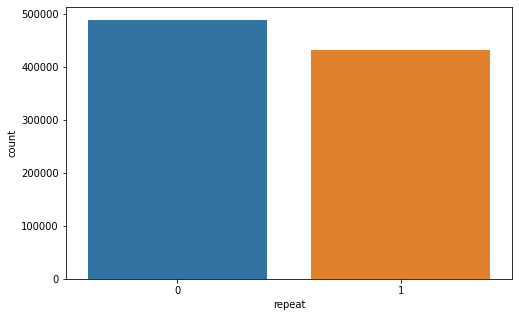

In [19]:
plt.figure(figsize=(8,5))
y_vis = y_train.to_frame()
sns.countplot(x = 'repeat', data = y_vis)

Text(0.5, 1.0, 'Sales by Chain and Customer Type')

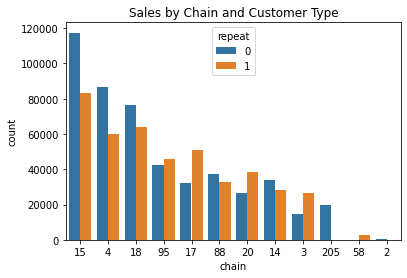

In [20]:
sns.countplot(x = 'chain', data = X_train, order = X_train['chain'].value_counts().index, hue = "repeat").set_title("Sales by Chain and Customer Type")

Text(0.5, 1.0, 'Sales by Dept for Repeat Customers')

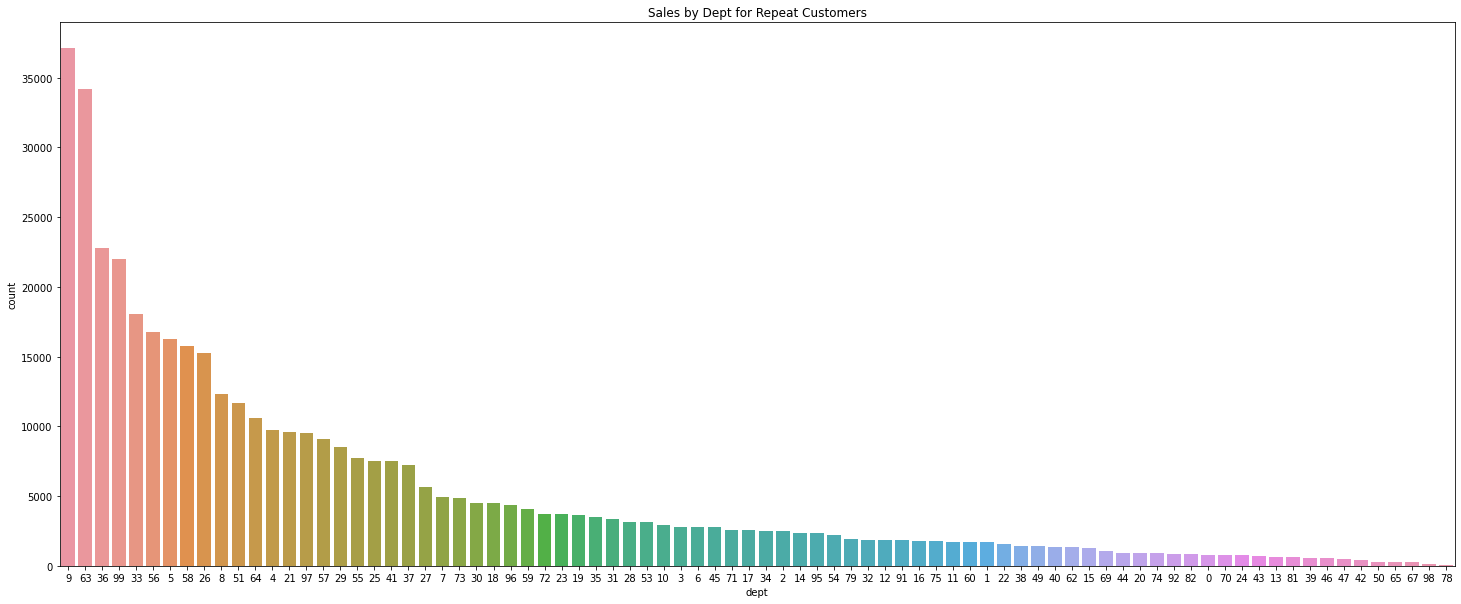

In [21]:
plt.figure(figsize=(25,10))
X_train_repeats = X_train[X_train['repeat'] == 1]
sns.countplot(x = 'dept', data = X_train_repeats, order = X_train_repeats['dept'].value_counts().index).set_title("Sales by Dept for Repeat Customers")

In [22]:
'''
color = ['dimgray', 'green', 'mediumorchid','cornflowerblue', 'crimson','orangered', 'navy', 'salmon']
sns.set(font_scale=3)
n_row = len(cols)
n_col = 2
n_sub = 1
fig = plt.figure(figsize=(20,40))
for i in range(len(cols) -2):
    plt.subplots_adjust(left=-0.3, right=1.3, bottom=-0.3, top=1.3)
    plt.subplot(n_row, n_col, n_sub)
    sns.distplot(numerical[cols[i]],norm_hist=False,kde=False, color=color[i],
                 label=['mean '+str('{:.2f}'.format(numerical.iloc[:,i].mean()))
                        +'\n''std '+str('{:.2f}'.format(numerical.iloc[:,i].std()))
                        +'\n''min '+str('{:.2f}'.format(numerical.iloc[:,i].min()))
                        +'\n''max '+str('{:.2f}'.format(numerical.iloc[:,i].max()))])                                                        
    n_sub+=1
    plt.legend()
plt.show()
'''

"\ncolor = ['dimgray', 'green', 'mediumorchid','cornflowerblue', 'crimson','orangered', 'navy', 'salmon']\nsns.set(font_scale=3)\nn_row = len(cols)\nn_col = 2\nn_sub = 1\nfig = plt.figure(figsize=(20,40))\nfor i in range(len(cols) -2):\n    plt.subplots_adjust(left=-0.3, right=1.3, bottom=-0.3, top=1.3)\n    plt.subplot(n_row, n_col, n_sub)\n    sns.distplot(numerical[cols[i]],norm_hist=False,kde=False, color=color[i],\n                 label=['mean '+str('{:.2f}'.format(numerical.iloc[:,i].mean()))\n                        +'\n''std '+str('{:.2f}'.format(numerical.iloc[:,i].std()))\n                        +'\n''min '+str('{:.2f}'.format(numerical.iloc[:,i].min()))\n                        +'\n''max '+str('{:.2f}'.format(numerical.iloc[:,i].max()))])                                                        \n    n_sub+=1\n    plt.legend()\nplt.show()\n"

In [23]:
#sns.set(font_scale=1)
#we sample 100k for significant reduction in loading times
#numerical = numerical.sample(n = 100000, random_state = 0)

In [24]:
'''
#'date_rel', productsize', 'purchasequantity', 'purchaseamount','brand', 'repeat', 'visits_60'

plot = sns.jointplot(data=numerical, x=cols[3], y=cols[-1], kind = 'reg', color=color[3],  marginal_ticks=True)
plot.ax_marg_x.set_xlim(0, 150)
plot.ax_marg_y.set_ylim(0, None)
plot.ax_joint.set_xlabel('Purchase Amount')
plot.ax_joint.set_ylabel('Visits in Last 60 Days')
plt.show()
'''

"\n#'date_rel', productsize', 'purchasequantity', 'purchaseamount','brand', 'repeat', 'visits_60'\n\nplot = sns.jointplot(data=numerical, x=cols[3], y=cols[-1], kind = 'reg', color=color[3],  marginal_ticks=True)\nplot.ax_marg_x.set_xlim(0, 150)\nplot.ax_marg_y.set_ylim(0, None)\nplot.ax_joint.set_xlabel('Purchase Amount')\nplot.ax_joint.set_ylabel('Visits in Last 60 Days')\nplt.show()\n"

In [25]:
'''
plot = sns.jointplot(data=numerical, x=cols[2], y=cols[-1], kind = 'reg', color=color[5],  marginal_ticks=True)
plot.ax_marg_x.set_xlim(0, None)
plot.ax_marg_y.set_ylim(0, None)
plot.ax_joint.set_xlabel('Purchase Quantity')
plot.ax_joint.set_ylabel('Visits in Last 60 Days')
plt.show()
'''

"\nplot = sns.jointplot(data=numerical, x=cols[2], y=cols[-1], kind = 'reg', color=color[5],  marginal_ticks=True)\nplot.ax_marg_x.set_xlim(0, None)\nplot.ax_marg_y.set_ylim(0, None)\nplot.ax_joint.set_xlabel('Purchase Quantity')\nplot.ax_joint.set_ylabel('Visits in Last 60 Days')\nplt.show()\n"

# Feature Engineering    

In [26]:
#Drop non-meaningful and y variables
X_train.drop(columns=['date'], inplace=True)
X_test.drop(columns=['date'], inplace=True)
X_train.drop(columns=['repeat'], inplace=True)
X_test.drop(columns=['repeat'], inplace=True)
X_train.drop(columns=['visits_60'], inplace=True)
X_test.drop(columns=['visits_60'], inplace=True)
X_train.columns

Index(['id', 'chain', 'dept', 'category', 'company', 'brand', 'date_rel',
       'productsize', 'productmeasure', 'purchasequantity', 'purchaseamount'],
      dtype='object')

In [27]:
from sklearn.preprocessing import LabelEncoder

#Use LE for productmeasure
pm_le = LabelEncoder() 
X_train['productmeasure'] = pm_le.fit_transform(X_train['productmeasure'])
X_test['productmeasure'] = pm_le.transform(X_test['productmeasure'])

In [28]:
'''
#Calculate MI scores
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y, discrete_features= 'auto', random_state = 0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train, y_train)
mi_scores.drop('id', inplace = True) #non-informative variable

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
'''

'\n#Calculate MI scores\nfrom sklearn.feature_selection import mutual_info_classif\n\ndef make_mi_scores(X, y):\n    mi_scores = mutual_info_classif(X, y, discrete_features= \'auto\', random_state = 0)\n    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)\n    mi_scores = mi_scores.sort_values(ascending=False)\n    return mi_scores\n\nmi_scores = make_mi_scores(X_train, y_train)\nmi_scores.drop(\'id\', inplace = True) #non-informative variable\n\ndef plot_mi_scores(scores):\n    scores = scores.sort_values(ascending=True)\n    width = np.arange(len(scores))\n    ticks = list(scores.index)\n    plt.barh(width, scores)\n    plt.yticks(width, ticks)\n    plt.title("Mutual Information Scores")\n\n\nplt.figure(dpi=100, figsize=(8, 5))\nplot_mi_scores(mi_scores)\n'

In [29]:
#oldest purchase
X_train["oldest_purchase"] = X_train.groupby(['id'], sort=False)['date_rel'].transform(max)
X_test["oldest_purchase"] = X_test.groupby(['id'], sort=False)['date_rel'].transform(max)

In [30]:
#Total purchased
X_train["total_purchased"] = X_train.groupby("id", as_index=False)['purchaseamount'].transform('sum')
X_test["total_purchased"] = X_train.groupby("id", as_index=False)['purchaseamount'].transform('sum')

In [31]:
#Chain variables
X_train["chain_total_sales"] = X_train.groupby("chain")['purchaseamount'].transform('sum')
X_test["chain_total_sales"] = X_test.groupby("chain")['purchaseamount'].transform('sum')
X_train["chain_unique_visits"] = X_train.groupby("chain")['date_rel'].transform('nunique')
X_test["chain_unique_visits"] = X_test.groupby("chain")['date_rel'].transform('nunique')
X_train["chain_unique_customers"] = X_train.groupby("chain")['id'].transform('nunique')
X_test["chain_unique_customers"] = X_test.groupby("chain")['id'].transform('nunique')

In [32]:
#Dept and Brand avg cost
X_train["dept_avg_cost"] = X_train.groupby("dept")['purchaseamount'].transform('mean')
X_test["dept_avg_cost"] = X_test.groupby("dept")['purchaseamount'].transform('mean')
X_train["brand_avg_cost"] = X_train.groupby("brand")['purchaseamount'].transform('mean')
X_test["brand_avg_cost"] = X_test.groupby("brand")['purchaseamount'].transform('mean')

In [33]:
#create target variable by checking if num trips in last 120 days > 1 
#visits_120 = num visits in last 120 days
#repeat = indicator of repeat customer 
X_train2 = X_train.copy()
X_train2 = X_train2[X_train2['date_rel'] <= 120]
X_train2['visits_120'] = X_train2.groupby('id')['date_rel'].transform("nunique")
X_train2['repeat'] = X_train2['visits_120'].apply(lambda x: 1 if x > 1 else 0)
X_train2.sort_values('repeat')
X_train = X_train.merge(X_train2.drop_duplicates(), how = "left")

#fill in NaN of customers who visited last 120 days and before that for date_rel older than 120
#The x.mean is just the same constant as visits_120 for that customer
X_train['visits_120'] = X_train.groupby(['id'], sort=False)['visits_120'].apply(lambda x: x.fillna(x.mean()))
X_train['repeat'] = X_train.groupby(['id'], sort=False)['repeat'].apply(lambda x: x.fillna(x.mean()))

#fill in all other customers
X_train['visits_120'] = X_train['visits_120'].fillna(0)
X_train['repeat'] = X_train['repeat'].fillna(0)

#float to int
X_train = X_train.astype({"visits_120":'int', "repeat":'int'}) 

#same to test
X_test2 = X_test.copy()
X_test2 = X_test2[X_test2['date_rel'] <= 120]
X_test2['visits_120'] = X_test2.groupby('id')['date_rel'].transform("nunique")
X_test2['repeat'] = X_test2['visits_120'].apply(lambda x: 1 if x > 1 else 0)
X_test2.sort_values('repeat')
X_test = X_test.merge(X_test2.drop_duplicates(), how = "left")

#fill in NaN of customers who visited last 120 days and before that 
X_test['visits_120'] = X_test.groupby(['id'], sort=False)['visits_120'].apply(lambda x: x.fillna(x.mean()))
X_test['repeat'] = X_test.groupby(['id'], sort=False)['repeat'].apply(lambda x: x.fillna(x.mean()))

#fill in other customers
X_test['visits_120'] = X_test['visits_120'].fillna(0)
X_test['repeat'] = X_test['repeat'].fillna(0)

#float to int
X_test = X_test.astype({"visits_120":'int', "repeat":'int'}) 


X_train.drop(columns=['repeat'], inplace=True)
X_test.drop(columns=['repeat'], inplace=True)

In [34]:
#Customer total visits
X_train['unique_visits'] = X_train.groupby('id')['date_rel'].transform('nunique')
X_test['unique_visits'] = X_test.groupby('id')['date_rel'].transform('nunique')

In [35]:
X_train.drop('id', axis = 1, inplace = True)
X_test.drop('id', axis = 1, inplace = True)

## Model Training

In [45]:
cat_features = [0,1,2,3,4,7]

from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=100, 
    random_seed = 0,
    learning_rate=0.05,
    verbose = False,
    cat_features=cat_features
)

scores_clf = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_micro')
print("Average f1 micro score:")
print(scores_clf.mean())

Average f1 micro score:
0.9580032608695653


In [44]:
from sklearn.model_selection import GridSearchCV
#parameter tuning
clf = CatBoostClassifier(random_seed = 0, verbose = False, cat_features=cat_features, learning_rate = 0.1)

grid = {'max_depth': [3,4,5],'n_estimators':[100, 200, 300]}
gscv = GridSearchCV(estimator = clf, param_grid = grid, scoring ='f1_micro', cv = 5)

gscv.fit(X_train, y_train)
print(gscv.best_estimator_)
print(gscv.best_score_)
print(gscv.best_params_)

KeyboardInterrupt: 

In [46]:
clf.fit(X_train, y_train, cat_features=cat_features, verbose = False)

In [49]:
from sklearn.metrics import f1_score
preds = clf.predict(X_test)
f1_score = f1_score(y_true = y_test, y_pred = preds, average='micro')
print(f1_score)

0.8993521739130435


In [ ]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(clf.get_feature_importance(),X_train.columns,'CATBOOST')